In [1]:
import healpy as hp
import numpy as np
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
import matplotlib.pyplot as plt
import os
import multiprocessing
from tqdm.notebook import tqdm

In [2]:
def mkdirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
# 这里应该选取2**10比较好，但是为了速度，选择了2**9
NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
Exptdata = np.load("./Exptdata_Ra_Dec.npz")
need = np.where((Exptdata["isgamma"] > 0.1) & (Exptdata["sumpf"] > 2.2))
Exptdata = {key: Exptdata[key][need] for key in Exptdata}
Exptdata["energy"] /= 1000

In [4]:
# 按不同的输出做背景
isgamma_bin = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99]

In [5]:
Energybin = np.logspace(0.6, 4, 18)
Energycenter = 10 ** ((np.log10(Energybin[1:]) + np.log10(Energybin[:-1])) / 2)

In [6]:
Acceptance = np.zeros([len(isgamma_bin), NPIX])
All = np.zeros([len(isgamma_bin), len(Energybin) - 1, NPIX])

In [7]:
for i, isgammamin in enumerate(isgamma_bin):
    need = np.where(Exptdata["isgamma"] > isgammamin)
    np.add.at(
        Acceptance[i],
        hp.ang2pix(NSIDE, Exptdata["ha"][need], Exptdata["Dec"][need], lonlat=True),
        1,
    )
    Acceptance[i] /= np.sum(Acceptance[i])

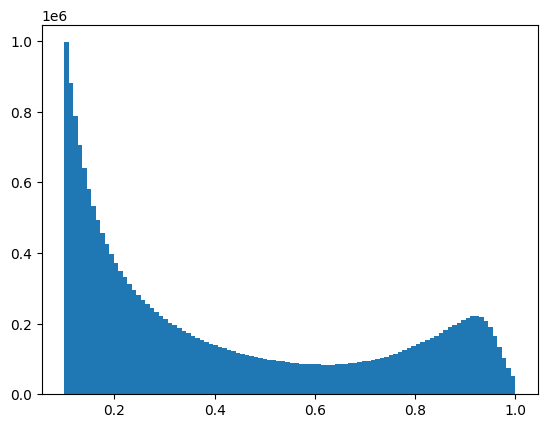

In [8]:
plt.hist(Exptdata["isgamma"], bins=100)
plt.show()

In [9]:
for i, isgammamin in enumerate(isgamma_bin):
    for Energy_i in range(len(Energycenter)):
        # print(isgamma_cut, Energy_i)
        need = np.where(
            (Exptdata["energy"] > Energybin[Energy_i])
            & (Exptdata["energy"] < Energybin[Energy_i + 1])
            & (Exptdata["isgamma"] > isgammamin)
        )

        np.add.at(
            All[i, Energy_i],
            hp.ang2pix(NSIDE, Exptdata["Ra"][need], Exptdata["Dec"][need], lonlat=True),
            1,
        )

In [10]:
np.save("./All.npy",All)

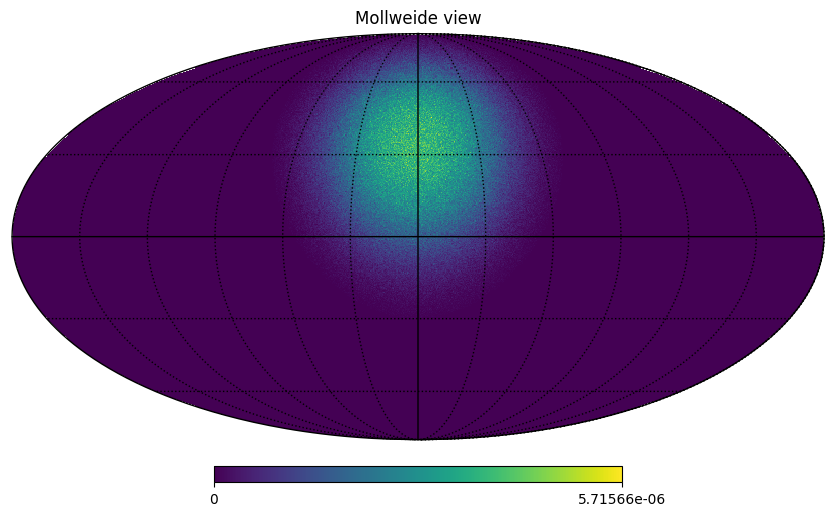

In [10]:
hp.mollview(Acceptance[0])
hp.graticule()

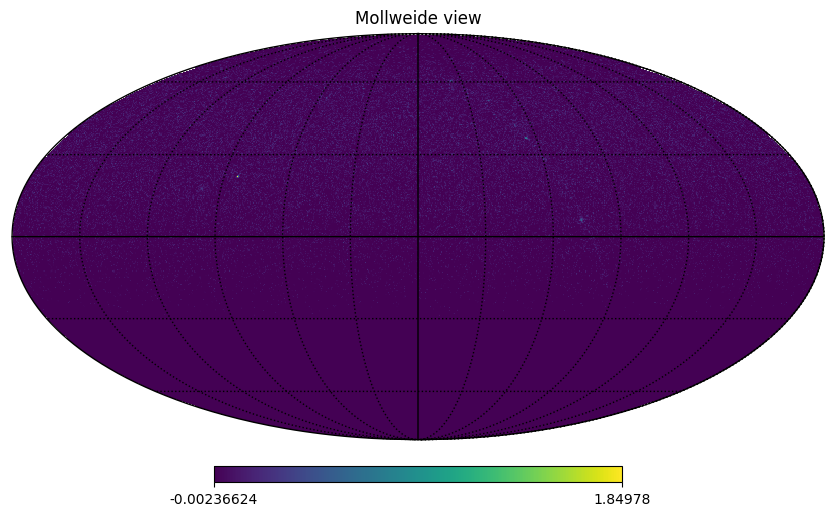

In [13]:
hp.mollview(hp.smoothing(np.sum(All[9], axis=0), fwhm=np.deg2rad(0.3)))
hp.graticule()

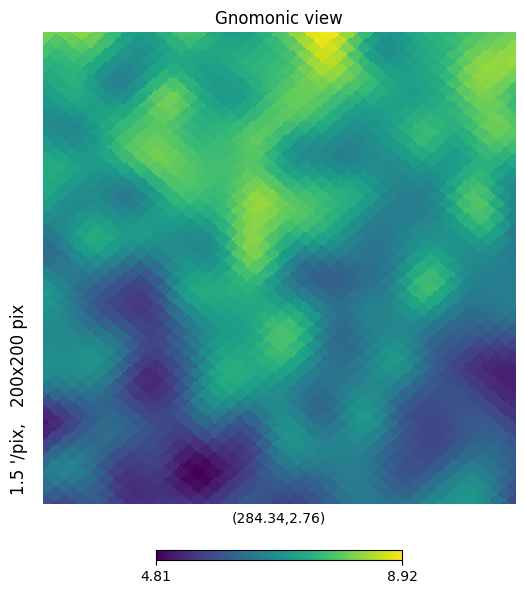

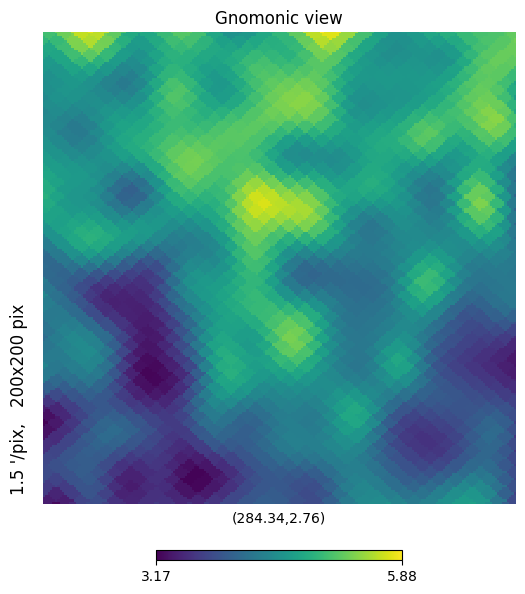

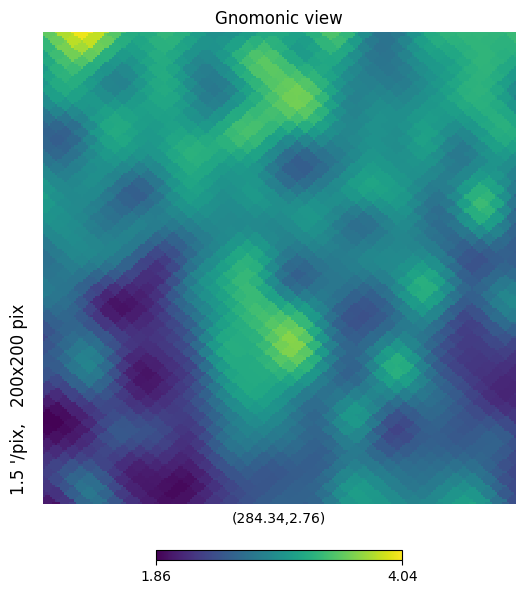

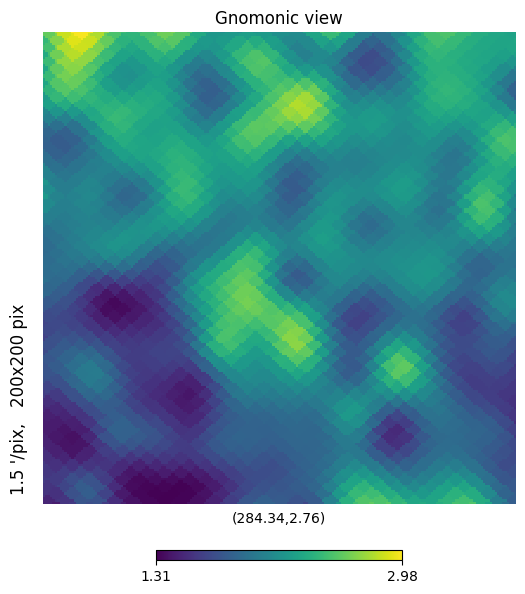

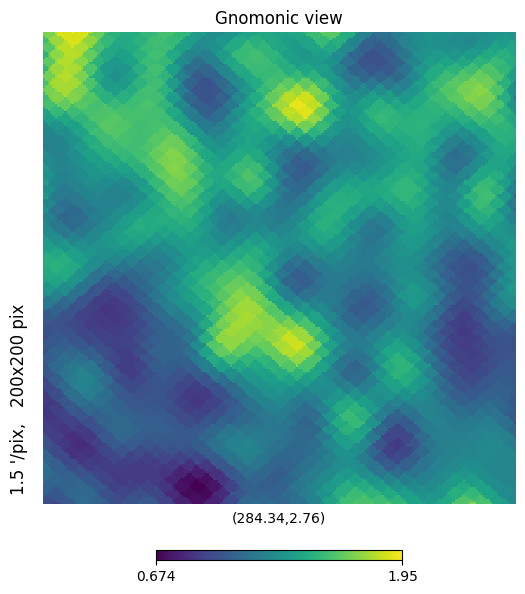

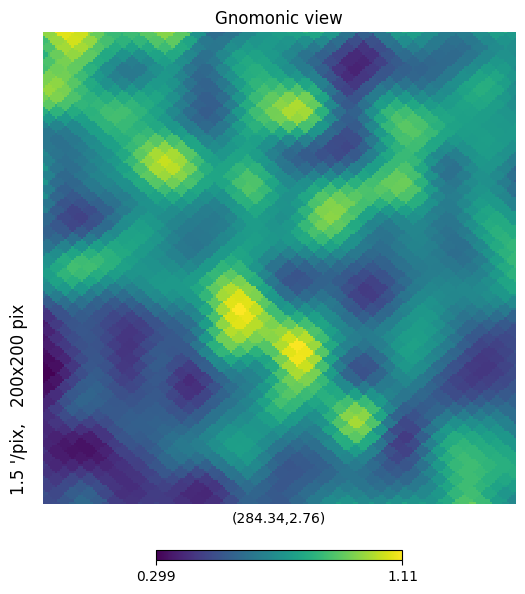

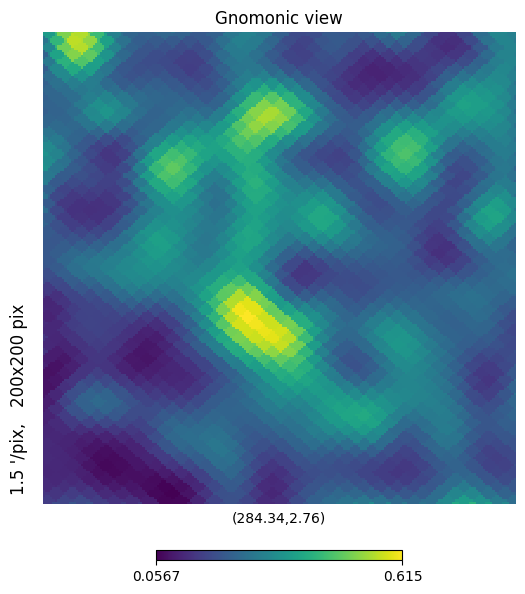

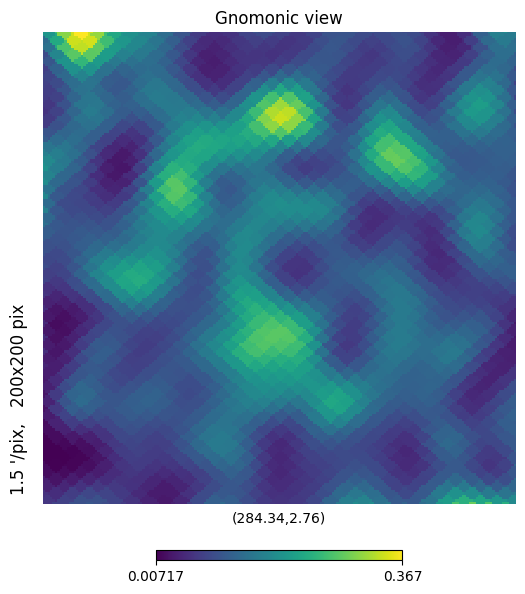

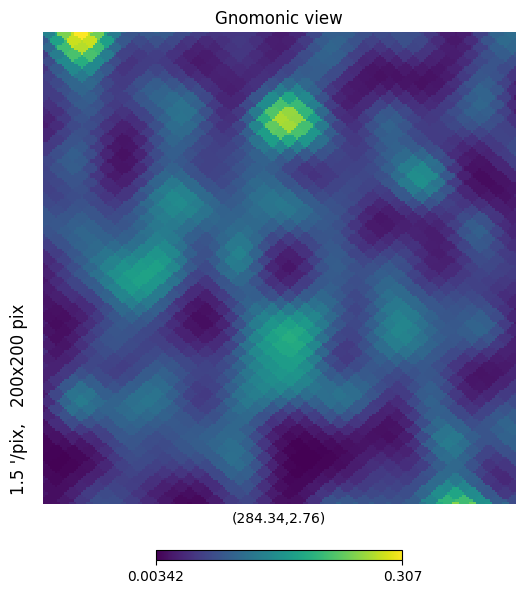

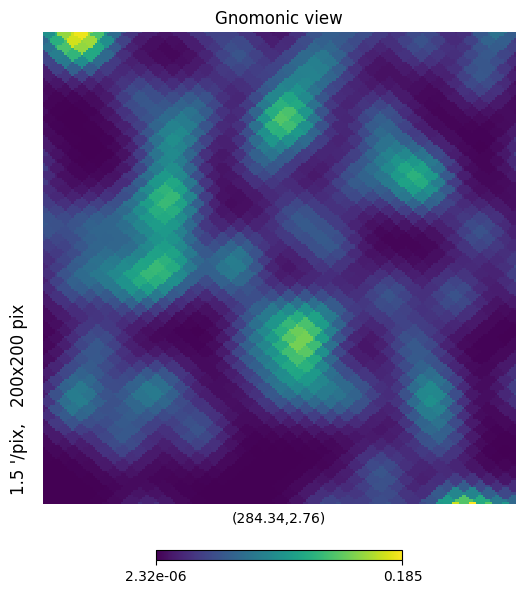

In [15]:
# 画图看一下crab区域的ALL
for i in range(len(isgamma_bin)):
    hp.gnomview(
        hp.smoothing(np.sum(All[i], axis=0), fwhm=np.radians(0.5)),
        rot=(284.34, 2.76),
    )

In [13]:
# 读取已知源数据
knowsource = np.load("./knownsource.npy")

In [14]:
Exptdata["ismasked"] = np.zeros_like(Exptdata["nch"])
Exptdata["ismasked"][np.where(knowsource[hp.ang2pix(NSIDE,Exptdata["Ra"],Exptdata["Dec"],lonlat=True)]==1)]=1

In [15]:
# 按mjd分bin
mjdbins = np.linspace(
    np.min(Exptdata["mjd"]) - 0.1,
    np.max(Exptdata["mjd"]) + 0.1,
    int((np.max(Exptdata["mjd"]) - np.min(Exptdata["mjd"])) * (4 * NSIDE)) + 1,
)
mjdcenter = (mjdbins[1:] + mjdbins[:-1]) / 2

In [16]:
mjd_content = np.zeros([len(isgamma_bin), len(Energybin) - 1, len(mjdcenter)])

In [17]:
for i, isgammamin in tqdm(enumerate(isgamma_bin)):
    for Energy_i in range(len(Energycenter)):
        # print(isgamma_cut, Energy_i)
        need = np.where(
            (Exptdata["energy"] > Energybin[Energy_i])
            & (Exptdata["energy"] < Energybin[Energy_i + 1])
            & (Exptdata["isgamma"] > isgammamin)
        )
        mjd_content[i, Energy_i], _ = np.histogram(Exptdata["mjd"][need], bins=mjdbins)

0it [00:00, ?it/s]

In [18]:
# 找到有事例的时间
mjdbins_need = np.where(np.sum(mjd_content, axis=(0, 1)) != 0)[0]
mjdbegin = mjdbins[mjdbins_need]
mjdend = mjdbins[mjdbins_need + 1]
mjd_content = mjd_content[:, :, mjdbins_need]
mjdcenter = mjdcenter[mjdbins_need]

In [19]:
# 计算每个mjd对应的恒星时
YBJ_Location = EarthLocation(lat=30.102 * u.deg, lon=90.522 * u.deg, height=4300 * u.m)
mjdtime = Time(mjdcenter, format="mjd", location=YBJ_Location)
mjdcenter_sidereal = mjdtime.sidereal_time("apparent").degree

In [20]:
pix_need = np.arange(NPIX)[np.where(np.sum(Acceptance, axis=0) != 0)]
Acceptance_need = Acceptance[:, pix_need]
theta, phi = hp.pix2ang(NSIDE, pix_need)

In [21]:
Background = np.zeros([len(isgamma_bin), len(Energybin) - 1, NPIX])

In [22]:
for mjd_i in tqdm(range(len(mjdcenter_sidereal))):
    Background_pix = hp.ang2pix(
        NSIDE, theta, np.deg2rad(mjdcenter_sidereal[mjd_i]) - phi
    )
    rate = 1 / (
        1
        - np.sum(
            Acceptance[
                :,
                np.where(knowsource[Background_pix] == 1)[0],
            ],
            axis=(1),
        )
    )
    for i, isgammamin in enumerate(isgamma_bin):
        need = np.where(
            (Exptdata["mjd"] > mjdbegin[mjd_i])
            & (Exptdata["mjd"] < mjdend[mjd_i])
            & (Exptdata["ismasked"] == 0)
            & (Exptdata["isgamma"] > isgammamin)
        )
        N_background, _ = np.histogram(Exptdata["energy"][need], bins=Energybin)
        N_background = N_background * rate[i]
        for j in range(len(Energycenter)):
            if N_background[j]!=0:
                np.add.at(
                    Background[i,j],
                    Background_pix,
                    N_background[j] * Acceptance_need[i],
                )


  0%|          | 0/1693483 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
savePath = "/home2/hky/github/Gamma_Energy/summary/Data/splitMJD"
mkdirs(savePath)
split = np.array_split(np.arange(len(mjdbegin)), 120)
for i, j in enumerate(split):
    np.save(os.path.join(savePath, f"mjdbegin{i}.npy"), mjdbegin[j])
    np.save(os.path.join(savePath, f"mjdend{i}.npy"), mjdend[j])
    np.save(os.path.join(savePath, f"mjd_sidereal{i}.npy"), mjdcenter_sidereal[j])
np.save(os.path.join(savePath, f"Acceptance.npy"),Acceptance)

In [28]:
np.savez("./Exptdata_with.npz",**Exptdata)